# Часть 2: методы оценки Value-at-Risk

### Библиотеки

In [1]:
pip install vartests

In [2]:
import pandas as pd
import numpy as np
import math
import random

import yfinance as yf

import datetime
from datetime import datetime

from copy import copy, deepcopy

import sys
import warnings
import os

In [3]:
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import norm, skewnorm, gennorm, t, nct, genpareto, genextreme, genhyperbolic, chi2, ncx2
from scipy.stats import skew, kurtosis
from sklearn.linear_model import LinearRegression

import vartests

0.2.2


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
folder = '/content/drive/MyDrive/Kagan_VKR/'

folder_dict = {'IMOEX': '1_imoex',
               'BCOMCO': '2_bcomco',
               'USD_RUB': '3_usd',
               'EUR_RUB': '4_eur',
               'Газпром': '5_gazprom'}

**Выгрузка данных**

In [7]:
if 'price_data.xlsx' in os.listdir(folder+'/data'):
    df_price = pd.read_excel(folder+'data/price_data.xlsx')
    df_price.set_index('Date', inplace=True)
else:
    print('Файл с данными не обнаружен!')

In [8]:
df_price.columns

Index(['EUR_RUB', 'USD_RUB', 'BCOMCO', 'IMOEX', 'Газпром'], dtype='object')

In [9]:
def calculate_returns(df, name):
    df_1 = df[name].dropna()
    return df_1.pct_change().dropna()

In [10]:
def calculate_var(name, returns):
    var_obj = VaR_calculation(returns=returns, name=name)

    res = pd.DataFrame()

    for w in window_list:
        for f in freq_list:
            df_cur = var_obj.backtest(window_size=w, recalibration_freq=f, return_=1)
            df_cur['Window'] = [w] * df_cur.shape[0]
            df_cur['Frequency'] = [f] * df_cur.shape[0]
            res = pd.concat([res, df_cur])

    res.to_excel(folder+folder_dict[name]+f"/{name}_var99.xlsx")

In [11]:
def download_data(name):
    d = pd.read_excel(folder+folder_dict[name]+f"/{name}_var99.xlsx")
    d.set_index('Date', inplace=True)
    return d

In [12]:
window_list = [250, 500, 750, 1000, 1250]

freq_list = [5, 25, 50, 75, 100, 150, 250]

# Value-at-Risk

### Классы

In [13]:
class VaR_calculation():
    def __init__(self, returns, name, confidence_level = 99):
        self.name = name
        self.returns = returns # ряд доходностей
        self.T = self.returns.shape[0]

        self.conf_level = confidence_level
        self.alpha = (100 - confidence_level) / 100

        self.models_info = {
            'HS': {'func': self.VAR_historical, 'dist': None, 'name': 'Исторический метод'},
            'norm': {'func': self.VAR_normal, 'dist': norm, 'name': 'Нормальное распределение'},
            'skew norm': {'func': self.VAR_skewnorm, 'dist': skewnorm, 'name': 'Скошенное нормальное распределение'},
            'GGD' : {'func': self.VAR_ggd, 'dist': gennorm, 'name': 'Обобщенное нормальное распределение'},
            't': {'func': self.VAR_students, 'dist': t, 'name': 'Распределение Стьюдента'},
            'nct': {'func': self.VAR_nct, 'dist': nct, 'name': 'Нецентральное распределение Стьюдента'},
            'GPD': {'func': self.VAR_gpd, 'dist': genpareto, 'name': 'Обобщенное Парето распределение'},
            'GEV': {'func': self.VAR_gev, 'dist': genextreme, 'name': 'Обобщенное распределение экстремальных значений'},
            'GHYP': {'func': self.VAR_ghyp, 'dist': genhyperbolic, 'name': 'Обобщенное гиперболическое распределение'}
        }
        #'CIR': {'func': self.VAR_cir, 'name': 'CIR процесс'}

        self.models_backtest = None # список моделей, для которых проводится бэктестирование
        self.df_var, self.N = None, None

        # Параметры распределений
        self.parametrs = {
            'norm': {'loc': 0, 'scale': 0},
            'skew norm': {'a': 0, 'loc': 0, 'scale': 0},
            'GGD' : {'beta': 0, 'loc': 0, 'scale': 0},
            't': {'df': 0, 'loc': 0, 'scale': 0},
            'nct': {'df': 0, 'nc': 0, 'loc': 0, 'scale': 0},
            'GPD': {'c': 0, 'loc': 0, 'scale': 0},
            'GEV': {'c': 0, 'loc': 0, 'scale': 0},
            'GHYP': {'p': 0, 'a': 0, 'b': 0, 'loc': 0, 'scale': 0}
            }

    def get_methods_list(self):
        """
            Ф-я возвращает список методов, доступных для расчета VaR.
        """
        print(self.models_info.keys())
        lst = [self.models_info[i]['name'] for i in self.models_info.keys()]
        print('\n'.join(lst))

    # Функция перекалибровки параметров
    def calculate_parametrs(self, df):
        models = deepcopy(self.models_backtest)
        if 'HS' in self.models_backtest:
            models.remove('HS')
        for dist in models:
            new_param = self.models_info[dist]['dist'].fit(df)
            for ind, p in enumerate(list(self.parametrs[dist].keys())):
                self.parametrs[dist][p] = new_param[ind]

    # Исторический метод
    def VAR_historical(self, returns=None):
        returns = self.returns if returns is None else returns
        return returns.quantile(self.alpha)

    # Нормальное распределение
    def VAR_normal(self, returns=None):
        returns = self.returns if returns is None else returns
        return stats.norm.ppf(self.alpha, loc=self.parametrs['norm']['loc'], scale=self.parametrs['norm']['scale'])

    # Скошенное нормальное распределение
    def VAR_skewnorm(self, returns=None):
        returns = self.returns if returns is None else returns
        return stats.skewnorm.ppf(self.alpha, a=self.parametrs['skew norm']['a'], loc=self.parametrs['skew norm']['loc'], scale=self.parametrs['skew norm']['scale'])

    # Обощенное нормальное распределение
    def VAR_ggd(self, returns=None):
        returns = self.returns if returns is None else returns
        return stats.gennorm.ppf(self.alpha, beta=self.parametrs['GGD']['beta'], loc=self.parametrs['GGD']['loc'], scale=self.parametrs['GGD']['scale'])

    # Распределение Стьюдента
    def VAR_students(self, returns=None, degrees_of_freedom=10):
        returns = self.returns if returns is None else returns
        return stats.t.ppf(self.alpha, degrees_of_freedom, loc=self.parametrs['t']['loc'], scale=self.parametrs['t']['scale'])

    # Нецентральное распределение Стьюдента
    def VAR_nct(self, returns=None, degrees_of_freedom=10):
        returns = self.returns if returns is None else returns
        return stats.nct.ppf(self.alpha, degrees_of_freedom, nc=self.parametrs['nct']['nc'], loc=self.parametrs['nct']['loc'], scale=self.parametrs['nct']['scale'])

    # Обощенное распределение Парето
    def VAR_gpd(self, returns=None):
        returns = self.returns if returns is None else returns
        return stats.genpareto.ppf(self.alpha, c=self.parametrs['GPD']['c'], loc=self.parametrs['GPD']['loc'], scale=self.parametrs['GPD']['scale'])

    # Обобщенное распределение экстремальных значений
    def VAR_gev(self, returns=None):
        returns = self.returns if returns is None else returns
        return stats.genextreme.ppf(self.alpha, c=self.parametrs['GEV']['c'], loc=self.parametrs['GEV']['loc'], scale=self.parametrs['GEV']['scale'])

    # Обобщенное гиперболическое распределение
    def VAR_ghyp(self, returns=None):
        returns = self.returns if returns is None else returns
        return stats.genhyperbolic.ppf(self.alpha, p=self.parametrs['GHYP']['p'], a=self.parametrs['GHYP']['a'], b=self.parametrs['GHYP']['b'],
                                       loc=self.parametrs['GHYP']['loc'], scale=self.parametrs['GHYP']['scale'])

    # Монте-Карло

    # Бэктестинг
    def backtest(self, window_size=250, recalibration_freq=100, models=None, return_=0):
        """
            Функция обратного тестирования.
            Если return_ = 1, возвращает DataFrame с результатми вычисления VaR для каждого момента времени различными моделями.
            models - cписок тестируемых моделей. По умолчанию ['HS', 'norm', 'skew norm', 'GGD', 't', 'nct', 'GPD', 'GEV', 'GHYP'].
            window_size - размер окна обучения.
            recalibration_freq - частота наблюдений, с которой переопределеяются параметры распределений.
        """
        self.models_backtest = list(self.models_info.keys()) if models is None else models

        #self.df_var_results = pd.DataFrame(index=self.models_backtest, columns=['Кол-во пробоев'])
        #self.df_var_results.fillna(0, inplace=True)

        self.df_var = deepcopy(self.returns).to_frame()
        c = 0

        for i in range(window_size, self.T):
            date = self.returns.index[i]
            ret = self.returns[i-window_size : i]
            if c % recalibration_freq == 0:
                self.calculate_parametrs(ret)
            c += 1
            for method in self.models_backtest:
                var_value = self.models_info[method]['func'](ret)
                self.df_var.loc[date, method] = var_value
                # Дополнительно проводим перекалибровку параметров после пробоя
                #if self.df_var.loc[date, self.name] < var_value:
                #    self.calculate_parametrs(ret)
                #    self.df_var_results.loc[method, 'Кол-во пробоев'] += 1

        self.df_var.dropna(inplace = True)
        self.N = self.df_var.shape[0]

        if return_:
            return self.df_var

    def get_var_results(self):
        """
            Ф-я возвращает DataFrame c результатами расчета VaR различными моделями.
        """
        return self.df_var

In [14]:
class VAR_visualisation():
    def __init__(self, name, df_var, confidence_level = 99, models=None):
        self.name = name
        self.df_var = df_var
        #self.T = self.df_var.shape[0]

        self.window_lst = pd.unique(self.df_var['Window'])
        self.freq_lst = pd.unique(self.df_var['Frequency'])

        self.conf_level = confidence_level
        self.alpha = (100 - confidence_level) / 100

        self.models_info = {
            'HS': {'name': 'Исторический метод', 'dist': None, 'c':'steelblue'},
            'norm': {'name': 'Нормальное распределение', 'dist': norm, 'c':'lightcoral'},
            'skew norm': {'name': 'Скошенное нормальное распределение', 'dist': skewnorm, 'c':'gold'},
            'GGD' : {'name': 'Обобщенное нормальное распределение', 'dist': gennorm, 'c':'orange'},
            't': {'name': 'Распределение Стьюдента', 'dist': t, 'c':'purple'},
            'nct': {'name': 'Нецентральное распределение Стьюдента', 'dist': nct, 'c':'brown'},
            'GPD': {'name': 'Обобщенное Парето распределение', 'dist': genpareto, 'c':'firebrick'},
            'GEV': {'name': 'Обобщенное распределение экстремальных значений', 'dist': genextreme, 'c':'seagreen'},
            'GHYP': {'name': 'Обобщенное гиперболическое распределение', 'dist': genhyperbolic, 'c':'orchid'}
        }

        # список моделей, для которых проводится бэктестированиеe
        self.models_backtest = list(self.models_info.keys()) if models is None else models

        self.color_dict = pd.Series(['honeydew', 'white'], index=[1, 0]).to_dict()

    def var_wf(self, window, freq):
        return self.df_var[(self.df_var['Window'] == window) & (self.df_var['Frequency'] == freq)]

    def calculate_breakdown(self, window, freq):
        """
            Ф-я возращает таблицу, в столбцах которой количество и доля пробоев, в строках - модели.
            window - окно обучения;
            freq - частота переобучения параметров.
        """
        df_wf = self.var_wf(window, freq)
        T = df_wf.shape[0]

        df_res = pd.DataFrame(index=self.models_backtest, columns = ['Кол-во пробоев'])
        for method in self.models_backtest:
             df_res.loc[method, 'Кол-во пробоев'] = np.sum(df_wf[self.name] < df_wf[method])
        df_res['Доля пробоев (%)'] = (df_res['Кол-во пробоев'] / T * 100).astype(float)
        df_res['Доля пробоев (%)'] = np.round(df_res['Доля пробоев (%)'], 2)
        return df_res

    def get_backtest_results(self):
        """
            Ф-я возращает таблицу, где для каждой пары (окно, частота перекалибровки параметров)
                отображается доля пробитий для различных моделей.
        """
        d = pd.DataFrame(index = pd.MultiIndex.from_product([self.window_lst, self.freq_lst], names=['Window','Freq']))
        for w in self.window_lst:
            for f in self.freq_lst:
                res = self.calculate_breakdown(w, f)
                for method in self.models_backtest:
                    d.loc[(w, f), self.models_info[method]['name']] = res.loc[method]['Доля пробоев (%)']
        print('Доля отклонений (%) \n')
        return d

    def plot_backtest(self, window, freq,
                      models=None,
                      fig_size = (18, 6)):
        """
            Ф-я отображает результаты бэктеста с заданными параметрами окна (window)
                    и частоты переобучения параметров(freq).
            models - список моделей, которые выводятся. По умолчанию все модели, для которых производился расчет.
        """
        models = self.models_backtest if models is None else models
        df_wf = self.var_wf(window, freq)
        fig, axs = plt.subplots(1, 1, figsize=fig_size)
        axs.plot(df_wf[self.name], color='silver', linewidth = 1, label = 'Returns')
        for m in models:
            axs.plot(df_wf[m], linewidth = 0.8, label = m, color=self.models_info[m]['c'])
        axs.legend()
        axs.set_title(f'{self.name}: VaR {self.conf_level}% \n Window = {window}, frequency = {freq}')
        plt.show()

    def plot_parametr_window(self, freq,
                        models=None,
                        fig_size = (16, 4)):
        """
            Зависимость доли отклонений от окна для заданной частоты перекалибровки параметров (freq) для различных моделей (models).
        """
        models = self.models_backtest if models is None else models

        fig, axs = plt.subplots(1, 1, figsize=fig_size)
        for model in models:
            ar = []
            for w in self.window_lst:
                ar.append(self.calculate_breakdown(w, freq).loc[model]['Доля пробоев (%)'])
            axs.plot(self.window_lst, ar, linewidth = 0.8, label = model, color=self.models_info[model]['c'])
        axs.set_xticks(self.window_lst)
        axs.set_xlabel('Размер окна')
        axs.set_ylabel('Доля отклонений (%)')
        axs.set_title(f'{self.name}: VaR {self.conf_level}% (frequency = {freq})')
        axs.legend(loc='upper right')
        plt.show()

    def plot_parametr_frequency(self, window,
                        models=None,
                        fig_size = (16, 4)):
        """
            Зависимость доли отклонений от частоты перекалибровки параметров для заданного окна (window) для различных моделей (models).
        """
        models = self.models_backtest if models is None else models

        fig, axs = plt.subplots(1, 1, figsize=fig_size)
        for model in models:
            ar = []
            for f in self.freq_lst:
                ar.append(self.calculate_breakdown(window, f).loc[model]['Доля пробоев (%)'])
            axs.plot(self.freq_lst, ar, linewidth = 0.8, label = model, color=self.models_info[model]['c'])
        axs.set_xticks(self.freq_lst)
        axs.set_xlabel('Частота перекалибровки параметров')
        axs.set_ylabel('Доля отклонений (%)')
        axs.set_title(f'{self.name}: VaR {self.conf_level}% (window = {window})')
        axs.legend(loc='upper right')
        plt.show()

    def test_kupiec(self, window, freq, lev=0.05, check=1):
        d = pd.DataFrame()
        df_wf = self.var_wf(window, freq)
        T = df_wf.shape[0]
        a = self.alpha
        for method in self.models_backtest:
            I = (df_wf[self.name] < df_wf[method]).astype(int)
            if check:
                print(vartests.kupiec_test(I, var_conf_level=0.99, conf_level=1-lev)) #сверяюсь с результатами библиотеки vartests
            k = np.sum(I)
            L_pof = -2 * np.log(((1 - a)**(T - k) * (a**k)) / ((1 - k/T)**(T-k) * ((k/T)**k)))
            p_value = chi2.sf(L_pof, df=1)
            d.loc[self.models_info[method]['name'], 'Kupiec POF'] = L_pof
            d.loc[self.models_info[method]['name'], 'p value'] = np.round(p_value, 5)
            d.loc[self.models_info[method]['name'], 'H0 принимается'] = 1 if p_value > lev else 0
        return d

    def test_kupiec_all(self, lev=0.05):
        """
            Ф-я возращает таблицу, где для каждой пары (окно, частота перекалибровки параметров)
                отображается результат теста Kupiec.
            1 - H0 не отвергается, модель принимается
            0 - модель не принимается
        """
        d = pd.DataFrame(index = pd.MultiIndex.from_product([self.window_lst, self.freq_lst], names=['Window','Freq']))
        for w in self.window_lst:
            for f in self.freq_lst:
                res = self.test_kupiec(w, f, lev, 0)
                for method in res.index:
                    d.loc[(w, f), method] = res.loc[method]['H0 принимается'].astype(int)
        d = d.style.applymap(lambda v: f"background-color: {self.color_dict.get(v, 'None')}").format('{:.0f}', na_rep='-')
        return d

    def test_christoffersen(self, window, freq, lev=0.05, check=1):
        d = pd.DataFrame()
        df_wf = self.var_wf(window, freq)
        T = df_wf.shape[0]
        for method in self.models_backtest:
            I = (df_wf[self.name] < df_wf[method]).astype(int)
            if check:
                print(vartests.duration_test(I, conf_level=1-lev)) #сверяюсь с результатами библиотеки vartests (хотя тест немного другой)
            n00, n01, n10, n11 = 0,0,0,0
            for t in range(1, len(I)):
                if I[t-1] == 0 and I[t] == 0:
                    n00 += 1
                elif I[t-1] == 0 and I[t] == 1:
                    n01 += 1
                elif I[t-1] == 1 and I[t] == 0:
                    n10 += 1
                else:
                    n11 += 1
            p0 = n01/(n00 + n01)
            p1 = n11/(n10 + n11)
            p = (n01 + n11)/(n00 + n01 + n10 + n11)
            L_ind = -2 * np.log((1 - p)**(n00 + n10) * p**(n01 + n11)) + 2 * np.log((1 - p0)**n00 * p0**n01 * (1 - p1)**n10 * p1**n11)
            p_value = chi2.sf(L_ind, df=1)
            d.loc[self.models_info[method]['name'], 'LR_ind'] = L_ind
            d.loc[self.models_info[method]['name'], 'p value'] = np.round(p_value, 5)
            d.loc[self.models_info[method]['name'], 'H0 принимается'] = 1 if p_value > lev else 0
        return d

    def test_christoffersen_all(self, lev=0.05):
        """
            Ф-я возращает таблицу, где для каждой пары (окно, частота перекалибровки параметров)
                отображается результат теста Christoffersen.
            1 - H0 не отвергается, модель принимается
            0 - модель не принимается
        """
        d = pd.DataFrame(index = pd.MultiIndex.from_product([self.window_lst, self.freq_lst], names=['Window','Freq']))
        for w in self.window_lst:
            for f in self.freq_lst:
                res = self.test_christoffersen(w, f, lev, 0)
                for method in res.index:
                    d.loc[(w, f), method] = res.loc[method]['H0 принимается'].astype(int)
        d = d.style.applymap(lambda v: f"background-color: {self.color_dict.get(v, 'None')}").format('{:.0f}', na_rep='-')
        return d

## IMOEX

In [ ]:
data_name = 'IMOEX'

In [ ]:
imoex = calculate_returns(df=df_price, name=data_name)

In [ ]:
imoex_var = VaR_calculation(returns=imoex, name=data_name)

In [ ]:
imoex_var.get_methods_list()

dict_keys(['HS', 'norm', 'skew norm', 'GGD', 't', 'nct', 'GPD', 'GEV', 'GHYP'])
Исторический метод
Нормальное распределение
Скошенное нормальное распределение
Обобщенное нормальное распределение
Распределение Стьюдента
Нецентральное распределение Стьюдента
Обобщенное Парето распределение
Обобщенное распределение экстремальных значений
Обобщенное гиперболическое распределение


In [ ]:
warnings.filterwarnings("ignore")

calculate_var(name=data_name, var_obj=imoex_var)

### Анализ полученных результатов

In [15]:
# Результаты вычисления VaR

df_imoex = download_data('IMOEX')

In [16]:
imoex_res = VAR_visualisation(name='IMOEX', df_var=df_imoex)

Тест Купика

In [17]:
imoex_res.test_kupiec(window=250, freq=50)

{'log-likelihood': 6.5331835632065065, 'chi square critical value': 3.841458820694124, 'null hypothesis': 'Probability of failure is 0.01', 'result': 'Reject H0'}
{'log-likelihood': 21.302451045827837, 'chi square critical value': 3.841458820694124, 'null hypothesis': 'Probability of failure is 0.01', 'result': 'Reject H0'}
{'log-likelihood': 16.012780752038097, 'chi square critical value': 3.841458820694124, 'null hypothesis': 'Probability of failure is 0.01', 'result': 'Reject H0'}
{'log-likelihood': 6.5331835632065065, 'chi square critical value': 3.841458820694124, 'null hypothesis': 'Probability of failure is 0.01', 'result': 'Reject H0'}
{'log-likelihood': 55.94292454621578, 'chi square critical value': 3.841458820694124, 'null hypothesis': 'Probability of failure is 0.01', 'result': 'Reject H0'}
{'log-likelihood': 60.06447794647721, 'chi square critical value': 3.841458820694124, 'null hypothesis': 'Probability of failure is 0.01', 'result': 'Reject H0'}
{'log-likelihood': 0.096

,Kupiec POF,p value,H0 принимается
Исторический метод,6.533184,0.01059,0.0
Нормальное распределение,21.302451,0.00000,0.0
Скошенное нормальное распределение,16.012781,0.00006,0.0
Обобщенное нормальное распределение,6.533184,0.01059,0.0
Распределение Стьюдента,55.942925,0.00000,0.0
Нецентральное распределение Стьюдента,60.064478,0.00000,0.0
Обобщенное Парето распределение,0.096711,0.75581,1.0
Обобщенное распределение экстремальных значений,2.350325,0.12526,1.0
Обобщенное гиперболическое распределение,13.604767,0.00023,0.0


In [18]:
imoex_res.test_kupiec_all()

Тест Кристофферсена

In [19]:
imoex_res.test_christoffersen(window=500, freq=25)

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
{'weibull exponential': array([0.622864]), 'unrestricted log-likelihood': array([-190.3692652]), 'restricted log-likelihood': array([-200.4528457]), 'log-likelihood': array([20.167161]), 'log-likelihood ratio test statistic': array([7.09607424e-06]), 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)', 'decision': 'Reject H0'}
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
{'weibull exponential': array([0.52940579]), 'unrestricted log-likelihood': array([-166.24691164]), 'restricted log-likelihood': array([-184.20053969]), 'log-likelihood': array([35.9072561]), 'log-likelihood ratio test statistic': array([2.06936623e-09]), 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)', 'decision': 'Reject H0'}
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
{'weibull exponential': array([0.53019816]), 'unrestricted log-likelihood': array([-165.51416457]), 'restricte

,LR_ind,p value,H0 принимается
Исторический метод,4.613343,0.03172,0.0
Нормальное распределение,5.660421,0.01735,0.0
Скошенное нормальное распределение,5.660421,0.01735,0.0
Обобщенное нормальное распределение,3.339047,0.06765,1.0
Распределение Стьюдента,9.792865,0.00175,0.0
Нецентральное распределение Стьюдента,8.809824,0.00300,0.0
Обобщенное Парето распределение,0.012769,0.91003,1.0
Обобщенное распределение экстремальных значений,0.289846,0.59032,1.0
Обобщенное гиперболическое распределение,8.740627,0.00311,0.0


In [20]:
imoex_res.test_christoffersen_all()

In [21]:
imoex_res.get_backtest_results()

Доля отклонений (%) 



Исторический метод  Нормальное распределение  \
Window Freq                                                 
250    25                  1.52                      1.74   
       50                  1.52                      1.99   
       100                 1.52                      2.25   
       150                 1.52                      2.25   
       250                 1.52                      2.75   
500    25                  1.63                      1.47   
       50                  1.63                      1.59   
       100                 1.63                      1.67   
       150                 1.63                      1.83   
       250                 1.63                      1.91   
750    25                  1.37                      1.64   
       50                  1.37                      1.81   
       100                 1.37                      1.86   
       150                 1.37                      1.99   
       250                 1.37                      2.26   
1000   25                  1.44                      1.74   
       50                  1.44                      1.94   
       100                 1.44                      1.99   
       150                 1.44                      2.19   
       250                 1.44                      2.39   
1250   25                  1.53                      1.93   
       50                  1.53                      2.16   
       100                 1.53                      2.27   
       150                 1.53                      2.27   
       250                 1.53                      2.73   

             Скошенное нормальное распределение  \
Window Freq                                       
250    25                                  1.70   
       50                                  1.85   
       100                                 2.10   
       150                                 2.21   
       250                                 2.75   
500    25                                  1.47   
       50                                  1.47   
       100                                 1.55   
       150                                 1.67   
       250                                 1.83   
750    25                                  1.46   
       50                                  1.59   
       100                                 1.64   
       150                                 1.68   
       250                                 1.99   
1000   25                                  1.54   
       50                                  1.74   
       100                                 1.79   
       150                                 1.94   
       250                                 2.09   
1250   25                                  1.82   
       50                                  2.04   
       100                                 2.10   
       150                                 2.10   
       250                                 2.44   

             Обобщенное нормальное распределение  Распределение Стьюдента  \
Window Freq                                                                 
250    25                                   1.41                     2.64   
       50                                   1.52                     2.72   
       100                                  1.74                     2.75   
       150                                  1.99                     2.75   
       250                                  2.32                     2.86   
500    25                                   1.27                     2.99   
       50                                   1.27                     2.95   
       100                                  1.43                     2.91   
       150                                  1.47                     3.07   
       250                                  1.67                     2.83   
750    25                                   1.37               

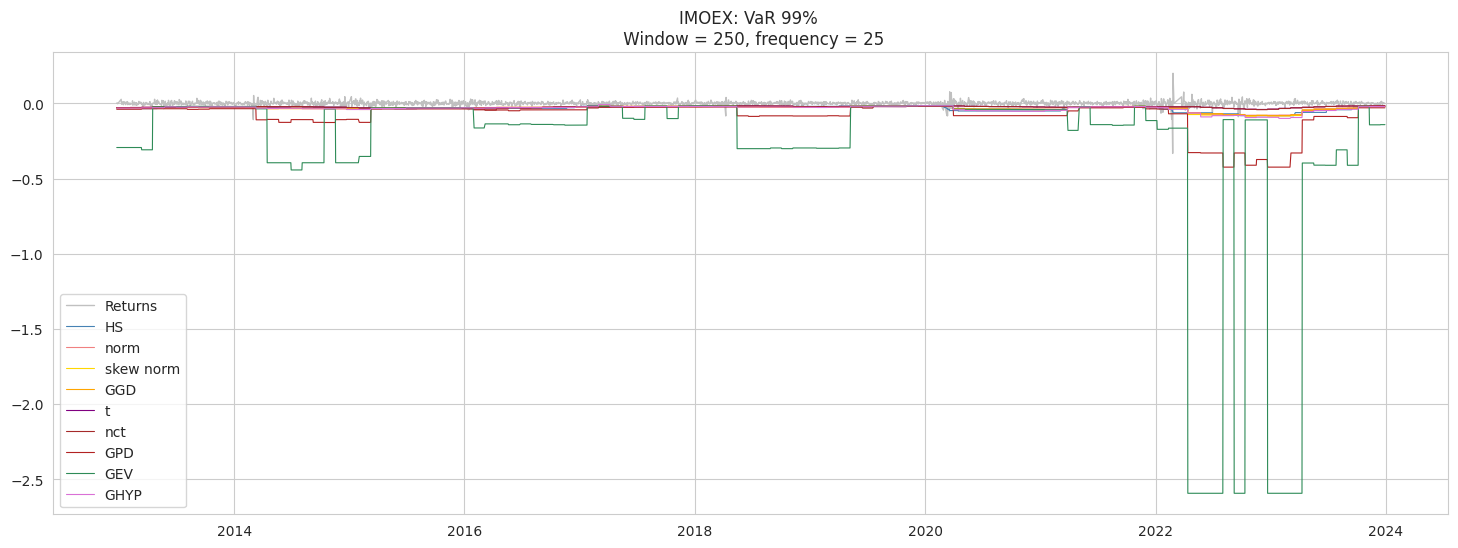

In [22]:
imoex_res.plot_backtest(window=250, freq=25)

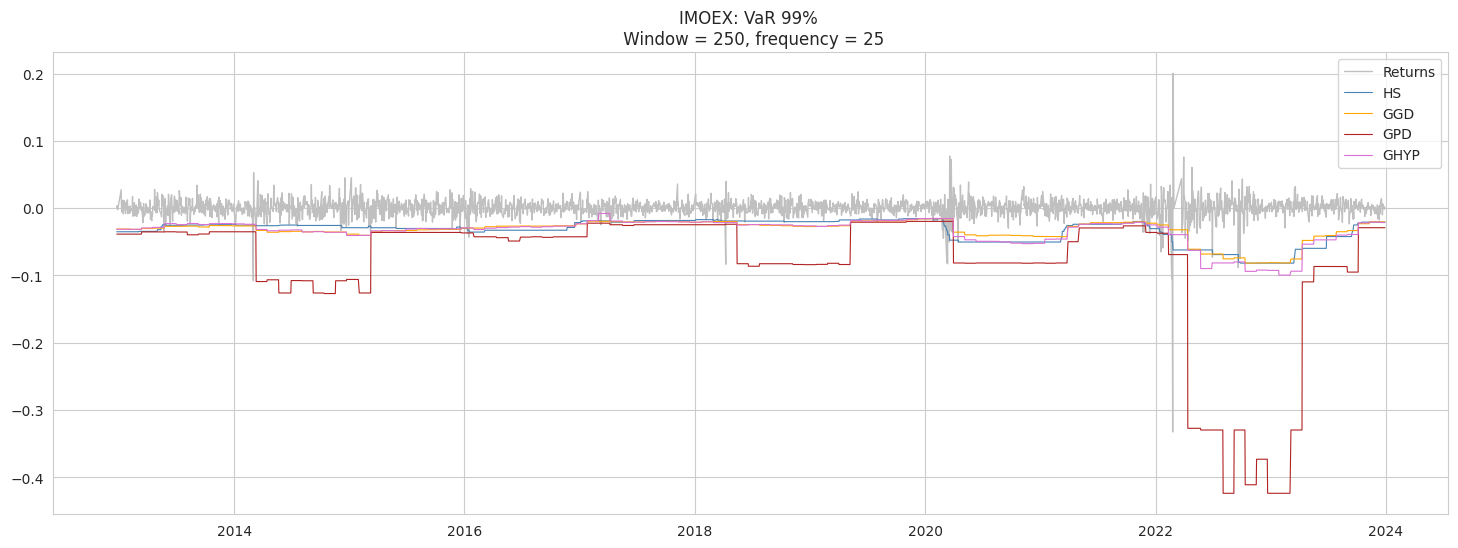

In [23]:
imoex_res.plot_backtest(window=250, freq=25, models=['HS', 'GGD', 'GPD', 'GHYP'])

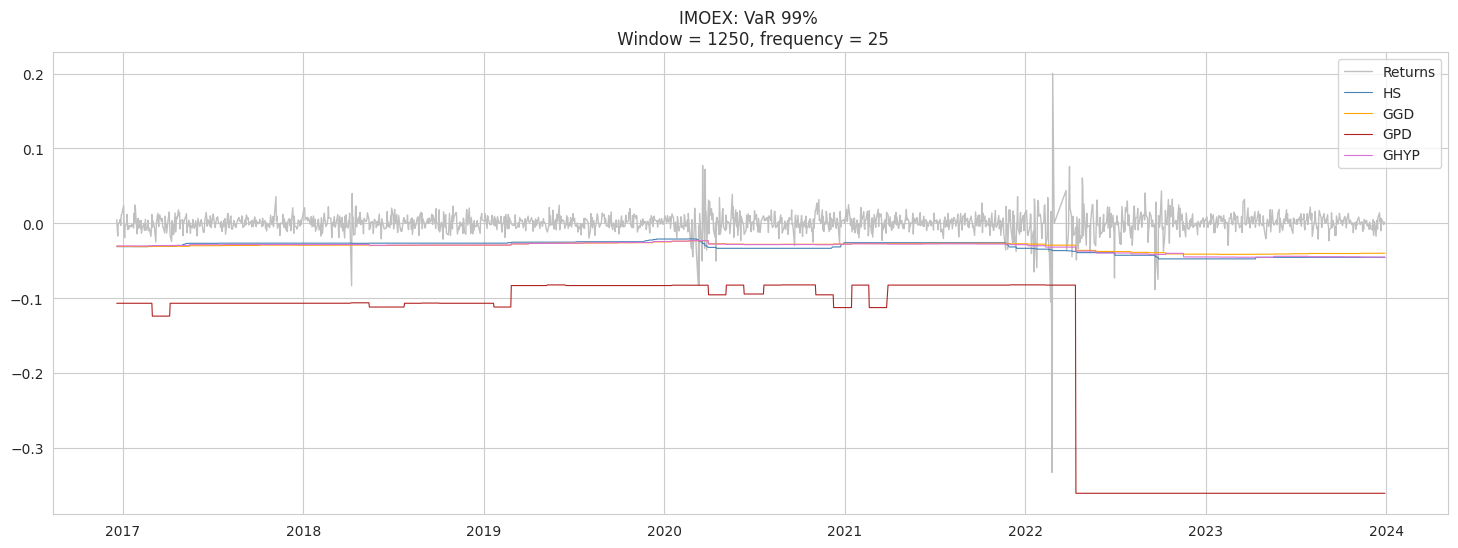

In [24]:
imoex_res.plot_backtest(window=1250, freq=25, models=['HS', 'GGD', 'GPD', 'GHYP'])

Зависимость доли отклонений одного параметра при фиксировании второго для различных моделей.

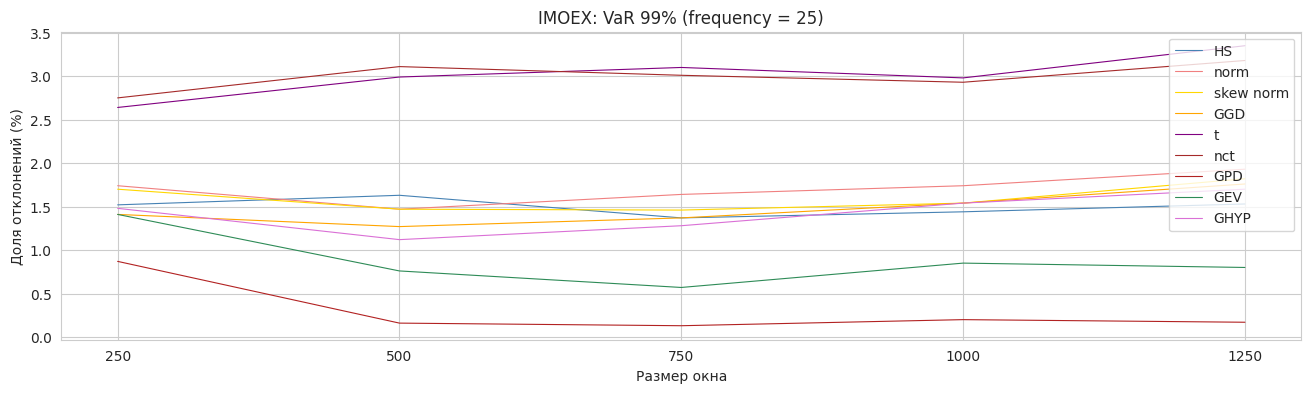

In [25]:
imoex_res.plot_parametr_window(freq=25)

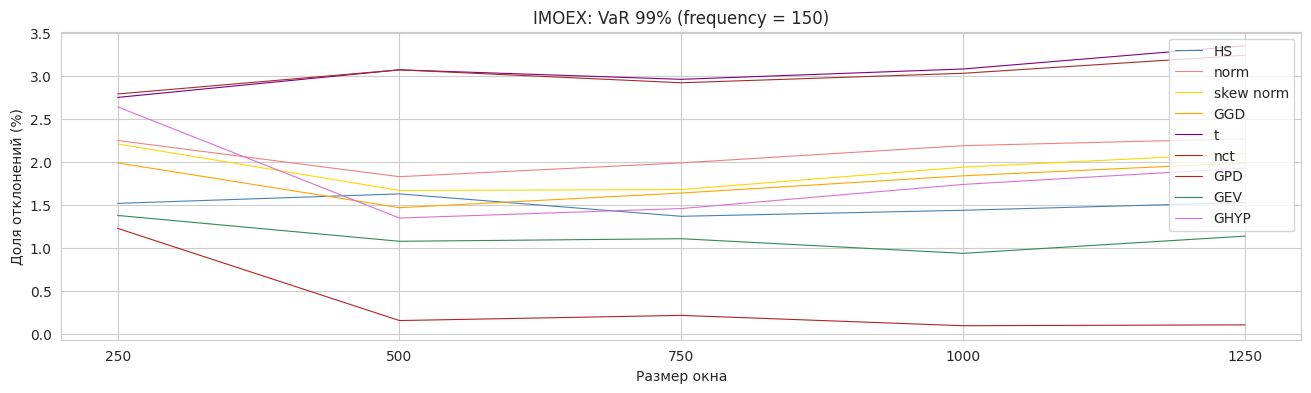

In [26]:
imoex_res.plot_parametr_window(freq=150)

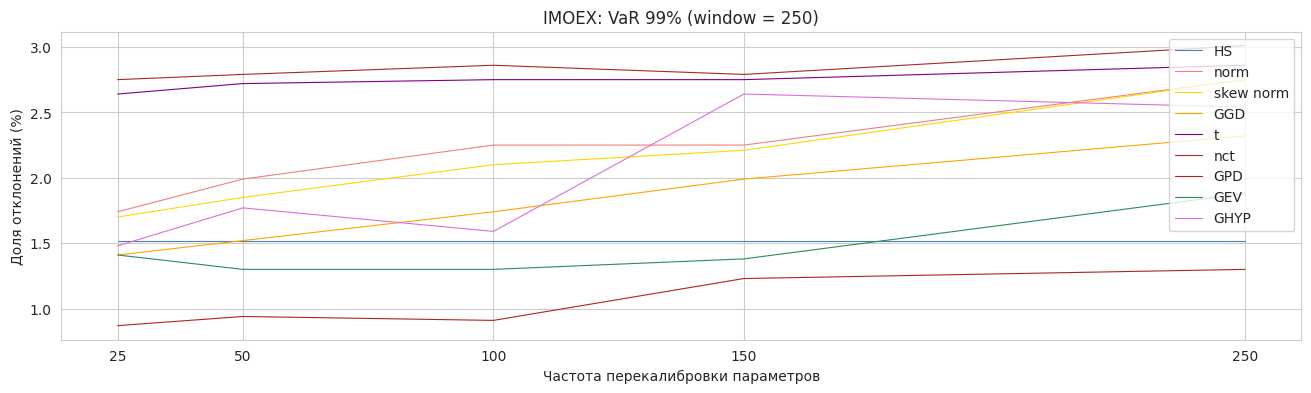

In [27]:
imoex_res.plot_parametr_frequency(window=250)

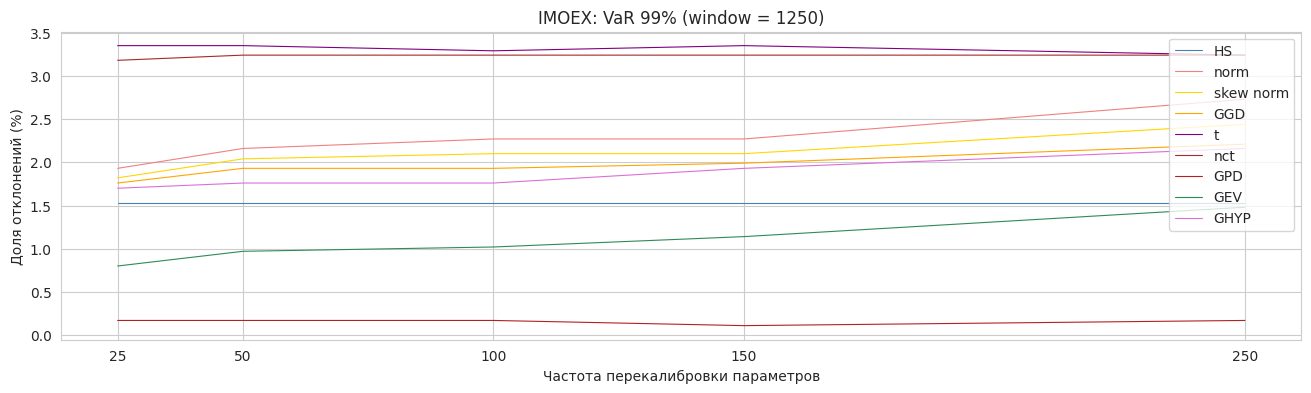

In [28]:
imoex_res.plot_parametr_frequency(window=1250)

## BCOMCO

In [ ]:
data_name = 'BCOMCO'
oil = calculate_returns(df=df_price, name=data_name)

In [ ]:
oil_var = VaR_calculation(returns=oil, name=data_name)

In [ ]:
warnings.filterwarnings("ignore")

calculate_var(name=data_name, var_obj=oil_var)

### Анализ полученных результатов

In [29]:
df_brent = download_data('BCOMCO')

In [32]:
oil_res = VAR_visualisation(name='BCOMCO', df_var=df_brent)

In [33]:
oil_res.test_kupiec_all()

In [34]:
oil_res.test_christoffersen_all()

In [35]:
oil_res.get_backtest_results()

Доля отклонений (%) 



Исторический метод  Нормальное распределение  \
Window Freq                                                 
250    25                  1.34                      2.24   
       50                  1.34                      2.45   
       100                 1.34                      2.74   
       150                 1.34                      3.14   
       250                 1.34                      3.10   
500    25                  1.55                      2.62   
       50                  1.55                      2.74   
       100                 1.55                      2.86   
       150                 1.55                      3.01   
       250                 1.55                      3.33   
750    25                  1.72                      2.51   
       50                  1.72                      2.64   
       100                 1.72                      2.82   
       150                 1.72                      2.82   
       250                 1.72                      3.39   
1000   25                  1.14                      1.93   
       50                  1.14                      1.93   
       100                 1.14                      1.93   
       150                 1.14                      2.08   
       250                 1.14                      2.08   
1250   25                  1.36                      1.75   
       50                  1.36                      1.86   
       100                 1.36                      1.98   
       150                 1.36                      1.98   
       250                 1.36                      1.92   

             Скошенное нормальное распределение  \
Window Freq                                       
250    25                                  2.17   
       50                                  2.31   
       100                                 2.45   
       150                                 2.96   
       250                                 2.81   
500    25                                  2.34   
       50                                  2.42   
       100                                 2.66   
       150                                 2.78   
       250                                 2.86   
750    25                                  2.38   
       50                                  2.47   
       100                                 2.64   
       150                                 2.60   
       250                                 3.04   
1000   25                                  2.03   
       50                                  2.03   
       100                                 2.03   
       150                                 2.13   
       250                                 2.18   
1250   25                                  1.75   
       50                                  1.86   
       100                                 2.03   
       150                                 1.86   
       250                                 1.86   

             Обобщенное нормальное распределение  Распределение Стьюдента  \
Window Freq                                                                 
250    25                                   1.84                     3.79   
       50                                   2.02                     3.90   
       100                                  2.27                     4.15   
       150                                  2.63                     4.40   
       250                                  2.53                     5.05   
500    25                                   1.94                     5.04   
       50                                   2.06                     5.20   
       100                                  2.22                     5.39   
       150                                  2.42                     5.71   
       250                                  2.54                     6.11   
750    25                                   1.81               

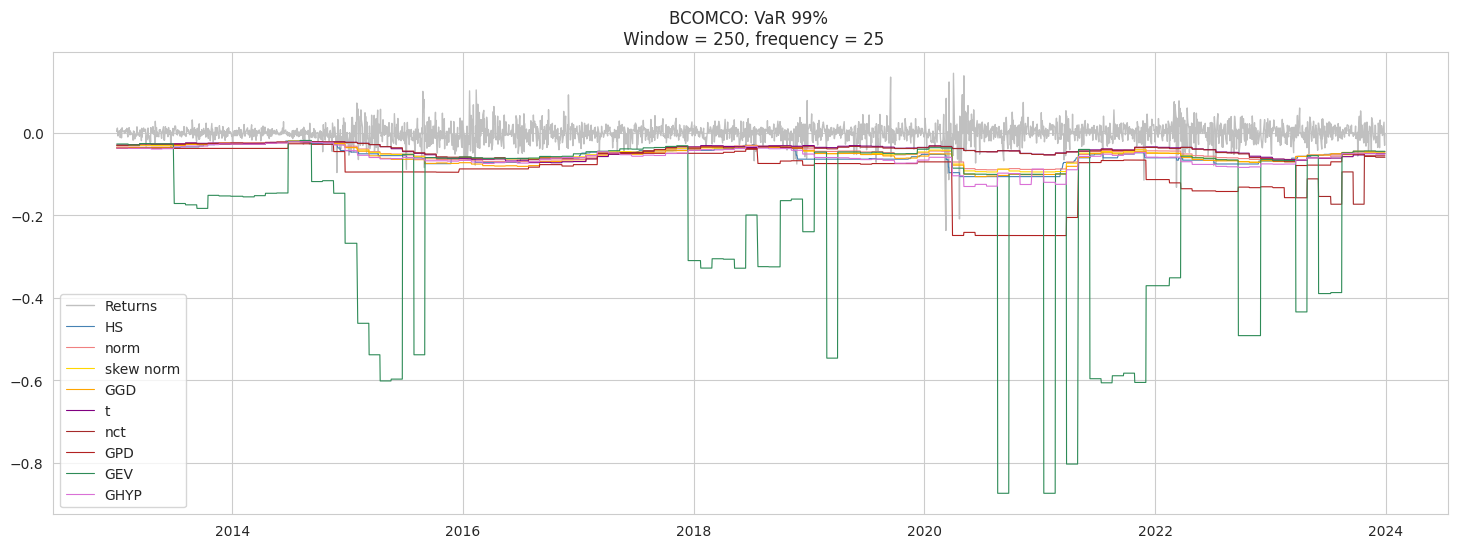

In [36]:
oil_res.plot_backtest(window=250, freq=25)

## Курс доллара

In [21]:
usd = calculate_returns(df=df_price, name='USD_RUB')

In [24]:
warnings.filterwarnings("ignore")

calculate_var(name='USD_RUB', returns=usd)

### Анализ полученных результатов

In [37]:
df_usd = download_data('USD_RUB')

In [38]:
usd_res = VAR_visualisation(name='USD_RUB', df_var=df_usd)

In [39]:
usd_res.test_kupiec(window=500, freq=25)

{'log-likelihood': 5.442517918525212, 'chi square critical value': 3.841458820694124, 'null hypothesis': 'Probability of failure is 0.01', 'result': 'Reject H0'}
{'log-likelihood': 10.075593889966669, 'chi square critical value': 3.841458820694124, 'null hypothesis': 'Probability of failure is 0.01', 'result': 'Reject H0'}
{'log-likelihood': 35.56815085033976, 'chi square critical value': 3.841458820694124, 'null hypothesis': 'Probability of failure is 0.01', 'result': 'Reject H0'}
{'log-likelihood': 3.9451722846786055, 'chi square critical value': 3.841458820694124, 'null hypothesis': 'Probability of failure is 0.01', 'result': 'Reject H0'}
{'log-likelihood': 336.675715595367, 'chi square critical value': 3.841458820694124, 'null hypothesis': 'Probability of failure is 0.01', 'result': 'Reject H0'}
{'log-likelihood': 340.4684679441221, 'chi square critical value': 3.841458820694124, 'null hypothesis': 'Probability of failure is 0.01', 'result': 'Reject H0'}
{'log-likelihood': 2.237580

,Kupiec POF,p value,H0 принимается
Исторический метод,5.442518,0.01965,0.0
Нормальное распределение,10.075594,0.00150,0.0
Скошенное нормальное распределение,35.568151,0.00000,0.0
Обобщенное нормальное распределение,3.945172,0.04701,0.0
Распределение Стьюдента,inf,0.00000,0.0
Нецентральное распределение Стьюдента,inf,0.00000,0.0
Обобщенное Парето распределение,2.237581,0.13469,1.0
Обобщенное распределение экстремальных значений,27.259218,0.00000,0.0
Обобщенное гиперболическое распределение,13.419395,0.00025,0.0


In [40]:
usd_res.test_kupiec_all()

In [41]:
usd_res.test_christoffersen(window=250, freq=25)

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
{'weibull exponential': array([0.60063888]), 'unrestricted log-likelihood': array([-230.12434977]), 'restricted log-likelihood': array([-245.01643858]), 'log-likelihood': array([29.78417762]), 'log-likelihood ratio test statistic': array([4.82917191e-08]), 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)', 'decision': 'Reject H0'}
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
{'weibull exponential': array([0.55540568]), 'unrestricted log-likelihood': array([-223.29976736]), 'restricted log-likelihood': array([-245.01643858]), 'log-likelihood': array([43.43334243]), 'log-likelihood ratio test statistic': array([4.38650227e-11]), 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)', 'decision': 'Reject H0'}
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
{'weibull exponential': array([0.56699593]), 'unrestricted log-likelihood': array([-263.15387559]), 're

,LR_ind,p value,H0 принимается
Исторический метод,9.949120,0.00161,0.0
Нормальное распределение,14.034034,0.00018,0.0
Скошенное нормальное распределение,21.592193,0.00000,0.0
Обобщенное нормальное распределение,18.637839,0.00002,0.0
Распределение Стьюдента,31.661440,0.00000,0.0
Нецентральное распределение Стьюдента,36.214021,0.00000,0.0
Обобщенное Парето распределение,12.936908,0.00032,0.0
Обобщенное распределение экстремальных значений,21.453689,0.00000,0.0
Обобщенное гиперболическое распределение,520.399924,0.00000,0.0


In [42]:
usd_res.test_christoffersen_all()

In [43]:
usd_res.get_backtest_results()

Доля отклонений (%) 



Исторический метод  Нормальное распределение  \
Window Freq                                                 
250    5                   1.74                      1.60   
       25                  1.74                      1.74   
       50                  1.74                      1.88   
       75                  1.74                      2.19   
       100                 1.74                      2.09   
       150                 1.74                      2.92   
       250                 1.74                      3.93   
500    5                   1.49                      1.64   
       25                  1.49                      1.68   
       50                  1.49                      1.90   
       75                  1.49                      2.17   
       100                 1.49                      2.55   
       150                 1.49                      3.01   
       250                 1.49                      4.08   
750    5                   1.64                      1.47   
       25                  1.64                      1.60   
       50                  1.64                      2.02   
       75                  1.64                      2.53   
       100                 1.64                      2.57   
       150                 1.64                      3.24   
       250                 1.64                      4.51   
1000   5                   1.60                      1.08   
       25                  1.60                      1.18   
       50                  1.60                      1.46   
       75                  1.60                      1.88   
       100                 1.60                      2.07   
       150                 1.60                      2.31   
       250                 1.60                      2.54   
1250   5                   1.55                      1.01   
       25                  1.55                      1.12   
       50                  1.55                      1.33   
       75                  1.55                      1.28   
       100                 1.55                      1.92   
       150                 1.55                      2.61   
       250                 1.55                      2.61   

             Скошенное нормальное распределение  \
Window Freq                                       
250    5                                   1.91   
       25                                  2.12   
       50                                  2.61   
       75                                  3.20   
       100                                 3.30   
       150                                 3.93   
       250                                 4.28   
500    5                                   2.06   
       25                                  2.36   
       50                                  2.90   
       75                                  2.67   
       100                                 3.24   
       150                                 3.73   
       250                                 4.99   
750    5                                   2.02   
       25                                  2.32   
       50                                  2.74   
       75                                  2.99   
       100                                 3.66   
       150                                 3.58   
       250                                 4.76   
1000   5                                   1.46   
       25                                  1.65   
       50                                  2.16   
       75                                  2.59   
       100                                 2.45   
       150                                 3.39   
       250                                 2.73   
1250   5                                   1.23   
       25                                  1.39   
       50                                  1.92   
       75                                  1.55   
       100           

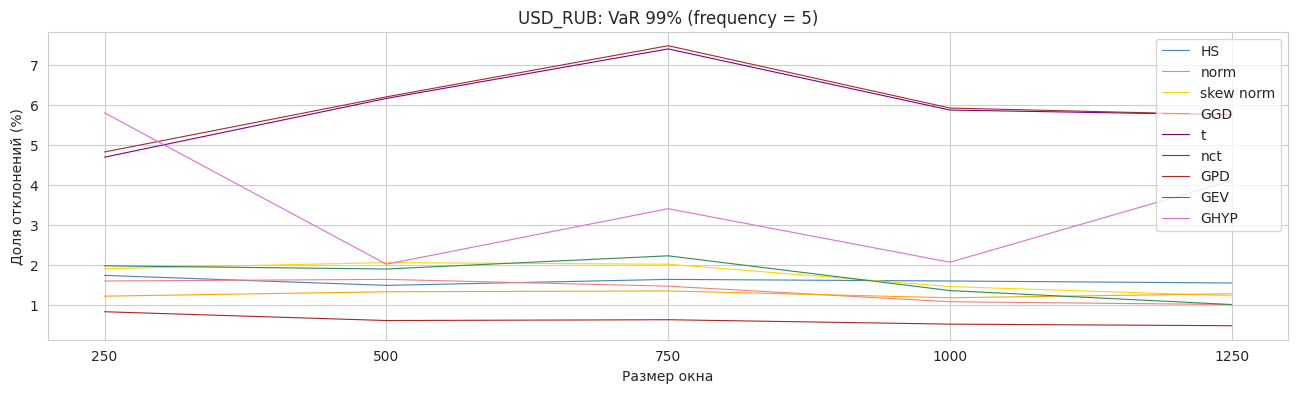

In [44]:
usd_res.plot_parametr_window(freq=5)

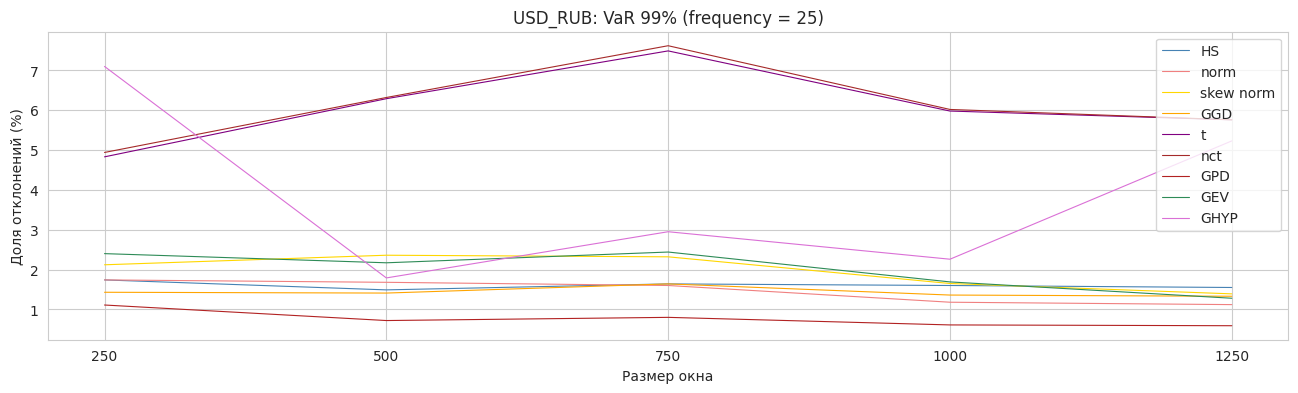

In [45]:
usd_res.plot_parametr_window(freq=25)

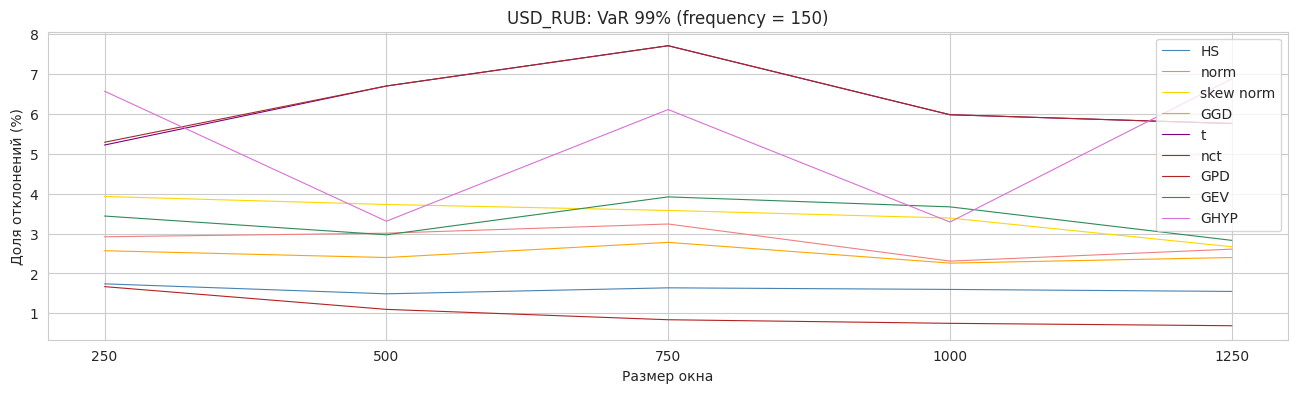

In [46]:
usd_res.plot_parametr_window(freq=150)

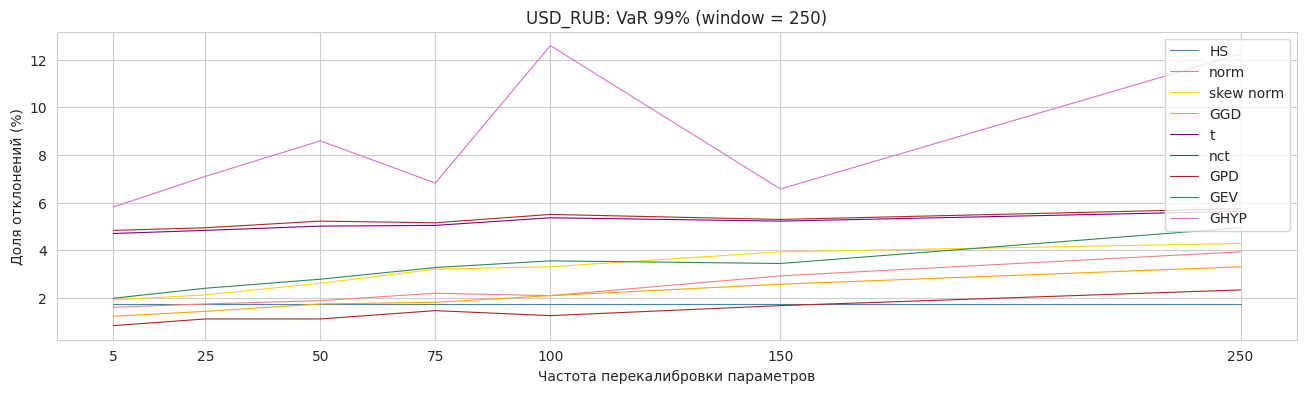

In [47]:
usd_res.plot_parametr_frequency(window=250)

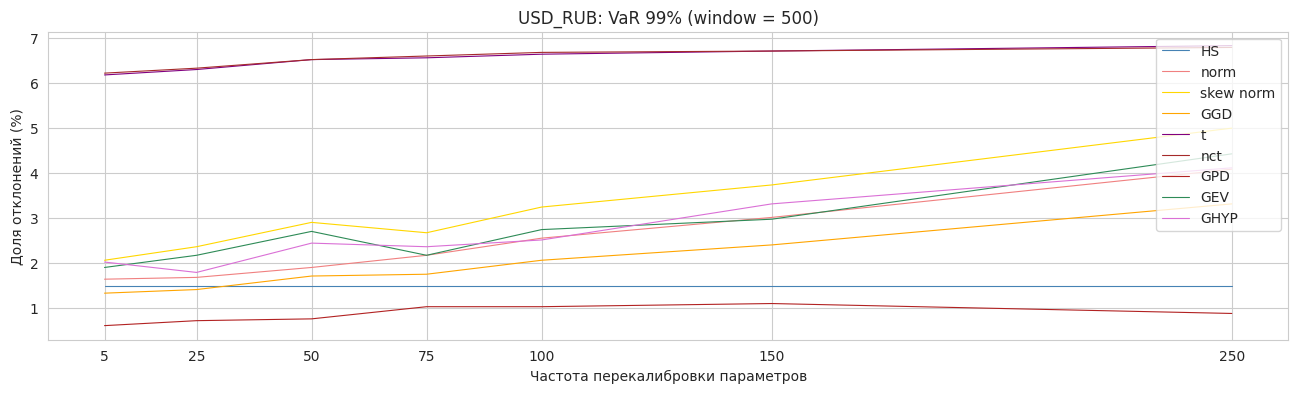

In [48]:
usd_res.plot_parametr_frequency(window=500)

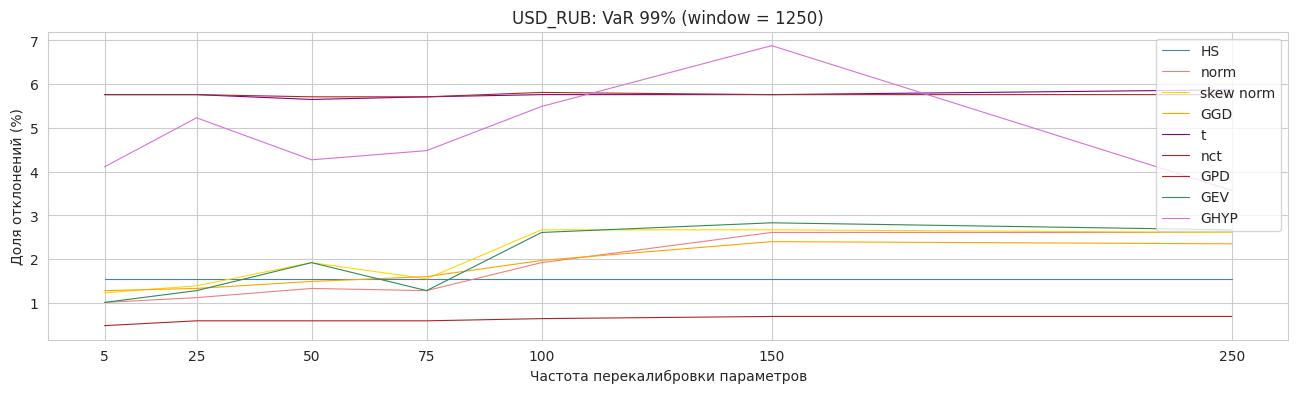

In [49]:
usd_res.plot_parametr_frequency(window=1250)

# стоп

## Курс евро

In [ ]:
data_name = 'EUR/RUB'
euro = calculate_returns(df=df_price, name=data_name)

In [ ]:
euro_var = VaR_calculation(returns=euro, name=data_name)

In [ ]:
warnings.filterwarnings("ignore")

calculate_var(name=data_name, var_obj=euro_var)

## Методы оценки модельного риска

In [ ]:
class Model_risk_calculation():
    def __init__(self, df_var, name, confidence_level = 99, models=None):
        self.df_var = deepcopy(df_var)
        self.N = self.df_var.shape[0]
        self.name = name

        self.conf_level = confidence_level
        self.alpha = (100 - confidence_level) / 100

        # Получение списка моделей, использованных для вычисления VaR
        if models is None:
            models = list(self.df_var.columns.drop(self.name))
        self.models = models

        self.models_info = {
            'HS': {'name': 'Исторический метод', 'c': 'steelblue'},
            'normal': {'name': 'Нормальное распределение', 'c': 'saddlebrown'},
            't': {'name': 'Распределение Стьюдента', 'c': 'goldenrod'},
            'GPD': {'name': 'Обобщенное распределение Парето', 'c': 'seagreen'},
            'GEV': {'name': 'Обобщенное распределение экстремальных значений', 'c': 'pink'},
            'GHYP': {'name': 'Обобщенное гиперболическое распределение', 'c': 'plum'}
        }

        self.df_res = self.calculate_breakdown()
        self.df_res['Доля пробоев (%)'] = self.df_res['Кол-во пробоев'] / self.N * 100
        print(self.df_res)

    def calculate_breakdown(self):
        df_res = pd.DataFrame(index=self.models, columns = ['Кол-во пробоев'])
        for method in self.models:
             df_res.loc[method, 'Кол-во пробоев'] = self.df_var[self.df_var[self.name] < self.df_var[method]].shape[0]
        return df_res

    def risk_ratio(self, return_=0, plot_=0, fig_size=(16, 4)):
        df_rr = pd.DataFrame(index = self.df_var.index)
        for d in self.df_var.index:
            val_lst = np.abs(self.df_var.loc[d][self.models].values)
            df_rr.loc[d, 'Risk Ratio'] = np.max(val_lst) / np.min(val_lst)

        if return_:
            return df_rr

        if plot_:
            fig, axs = plt.subplots(1, 1, figsize=fig_size)
            axs.plot(df_rr['Risk Ratio'], color='dimgrey')
            axs.set_title(f"Risk Ratio (mean = {np.round(np.mean(df_rr['Risk Ratio']), 2)})")
            axs.axhline(y=1, color='salmon', linestyle = '--', linewidth=0.8)
            plt.show()

    def absolute_measure(self, plot_=0, fig_size=(15, 5)):
        df_am = pd.DataFrame(index = self.df_var.index, columns=self.models)
        for d in self.df_var.index:
            var_lst = np.abs(self.df_var.loc[d][self.models].values)
            var_max = np.max(var_lst)
            df_am.loc[d] = var_max / var_lst - 1

        if plot_:
            fig, axs = plt.subplots(1, 1, figsize=fig_size)
            for method in df_am.columns:
                axs.plot(df_am[method], label=self.models_info[method]['name'], color=self.models_info[method]['c'])
            axs.set_title("Absolute measure")
            axs.legend()
            plt.show()

    def relative_measure(self, plot_=0, fig_size=(15, 5)):
        df_rm = pd.DataFrame(index = self.df_var.index, columns=self.models)
        for d in self.df_var.index:
            var_lst = np.abs(self.df_var.loc[d][self.models].values)
            var_max = np.max(var_lst)
            var_min = np.min(var_lst)
            df_rm.loc[d] = (var_max - var_lst ) / (var_max - var_min)

        if plot_:
            fig, axs = plt.subplots(1, 1, figsize=fig_size)
            for method in df_rm.columns:
                axs.plot(df_rm[method], label=self.models_info[method]['name'], color=self.models_info[method]['c'])
            axs.set_title("Relative measure")
            axs.legend()
            plt.show()

    def mean_relative_deviation(self, plot_=0, fig_size=(15, 5)):
        df_mrd = pd.DataFrame(index = self.df_var.index, columns=self.models)
        for d in self.df_var.index:
            var_lst = np.abs(self.df_var.loc[d][self.models].values)
            var_mean = np.mean(var_lst)
            df_mrd.loc[d] = var_lst / var_mean - 1

        if plot_:
            fig, axs = plt.subplots(1, 1, figsize=fig_size)
            for method in df_mrd.columns:
                axs.plot(df_mrd[method], label=self.models_info[method]['name'], color=self.models_info[method]['c'])
            axs.axhline(y=0, color='salmon', linestyle = '--', linewidth=0.8)
            axs.set_title("Mean relative deviation")
            axs.legend()
            plt.show()

    def modified_binary_loss_func(self, plot_=0, fig_size=(15, 5)):
        self.df_res['MBLF'] = np.abs(self.df_res['Кол-во пробоев'] / self.N - self.alpha)

In [ ]:
df_var_imoex = pd.read_excel('var_imoex_14_23_w1250.xlsx').set_index('Date')

In [ ]:
df_var_imoex.head(5)

In [ ]:
imoex_mr = Model_risk_calculation(df_var = df_var_imoex, name = 'IMOEX', confidence_level = 99)

       Кол-во пробоев Доля пробоев (%)
HS                 27         1.994092
normal             32         2.363368
t                  66         4.874446
GPD                 2          0.14771


In [ ]:
imoex_mr.modified_binary_loss_func()

In [ ]:
imoex_mr.df_res

,Кол-во пробоев,Доля пробоев (%),MBLF
HS,27,1.994092,0.009941
normal,32,2.363368,0.013634
t,66,4.874446,0.038744
GPD,2,0.14771,0.008523


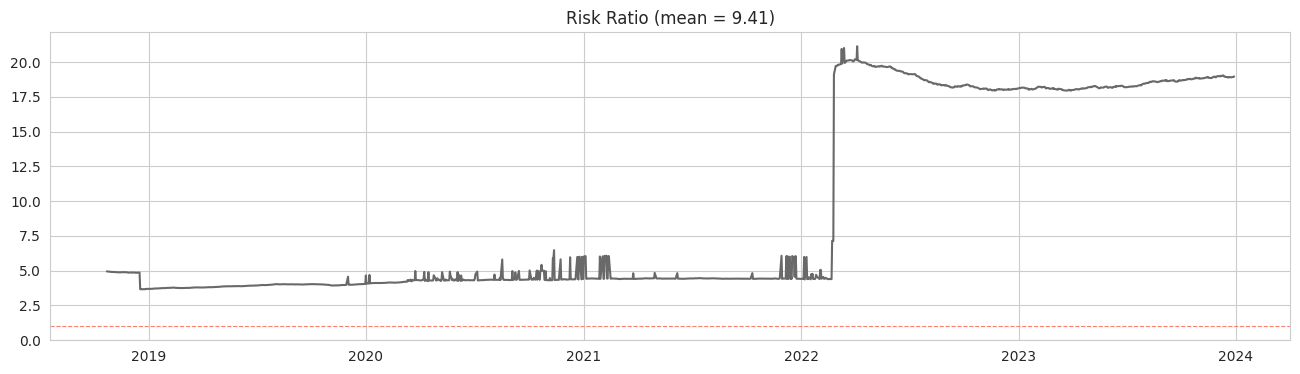

In [ ]:
imoex_mr.risk_ratio(plot_=1)

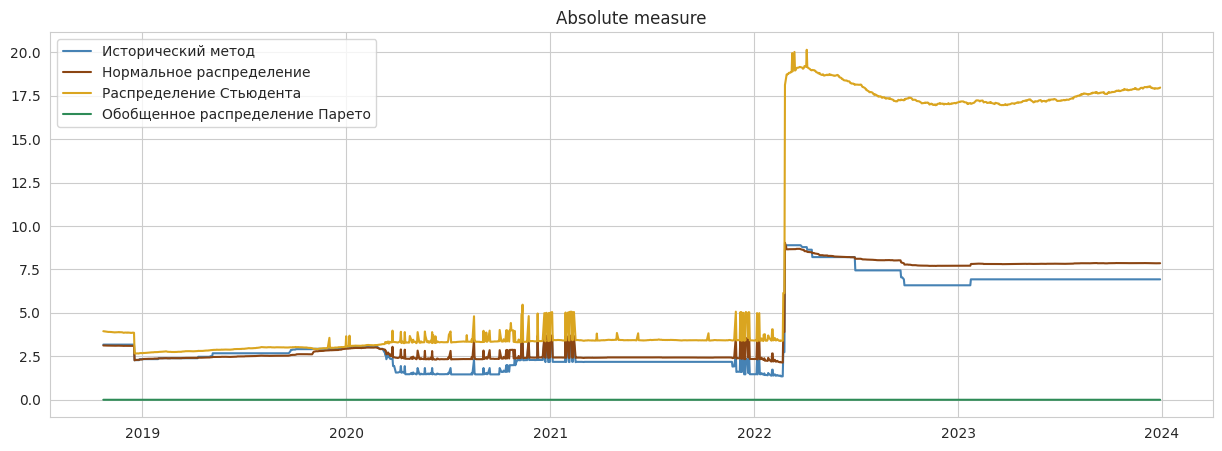

In [ ]:
imoex_mr.absolute_measure(plot_=1)

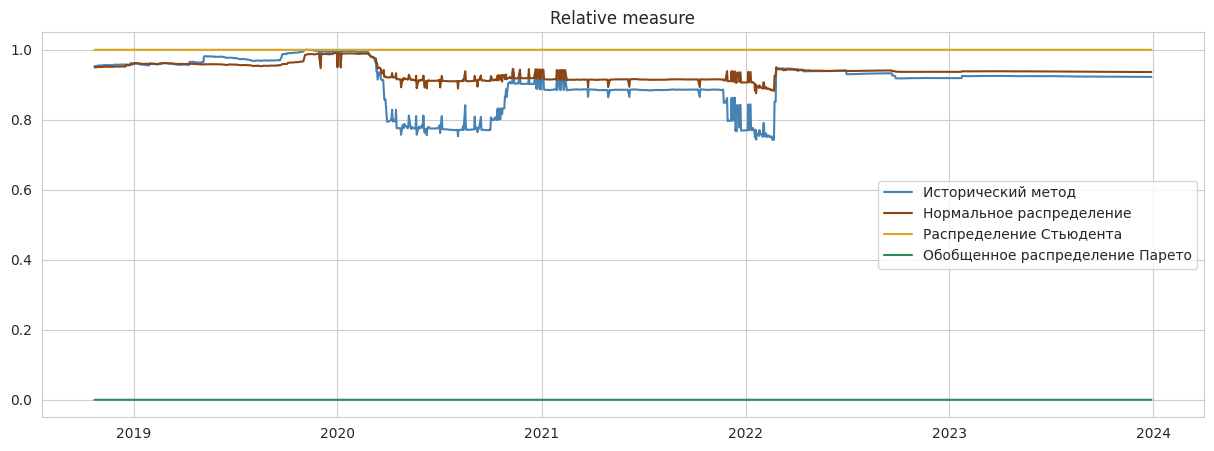

In [ ]:
imoex_mr.relative_measure(plot_=1)

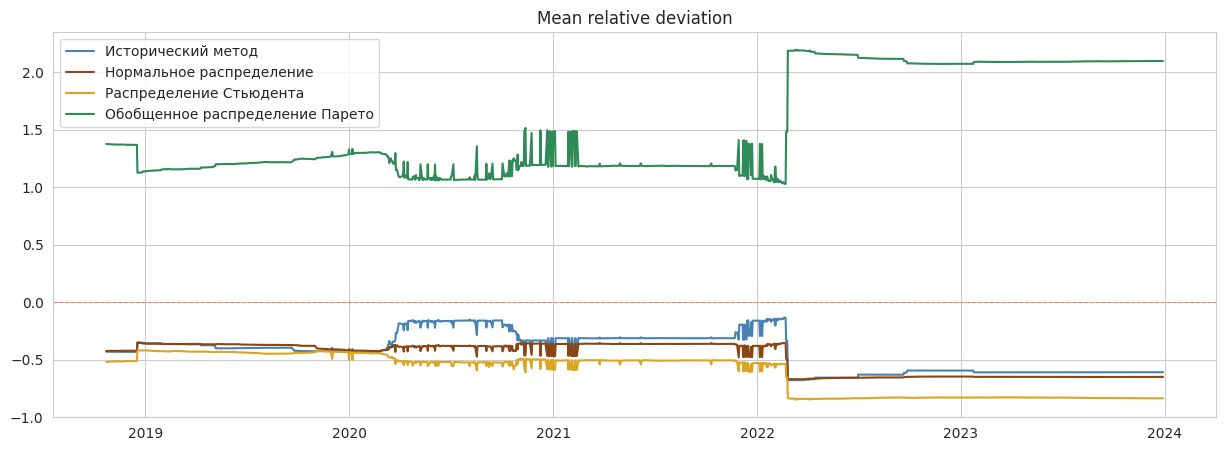

In [ ]:
imoex_mr.mean_relative_deviation(plot_=1)